<a href="https://colab.research.google.com/github/luanakwon/ML_Pytorch_pre2022/blob/main/TorchPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 
---
Predicting hand written numbers with CNN model.  
  
  
(pytorch prctice with mnist data. didn't even know how to use matplotlib nor cv2 back then)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

In [2]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [15]:
mnist_train = dset.MNIST("./",train=True, transform=transforms.ToTensor(),target_transform=None, download=True)
mnist_test = dset.MNIST("./",train=False, transform=transforms.ToTensor(),target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

print(f'Train dataset : \n {mnist_train}')
print('='*30)
print(f'Test dataset : \n {mnist_test}')

Train dataset : 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()
Test dataset : 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
from torch.nn.modules.activation import Sigmoid
class CNNClassifier(nn.Module):
  def __init__(self):
    super(CNNClassifier,self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(1,16,5),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16,32,5),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,5),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*3*3,100),
        nn.ReLU(),
        nn.Linear(100,10),
        nn.Softmax(10)
    )
  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)
    return out

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
tr_loss_array = []
te_loss_array = []

for e in range(num_epoch):
  # train 
  for i, [image,label] in enumerate(train_loader):
    x = image.to(device)
    y_= label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if i%64==0:
      print(f'\rTRAIN [{e}/{num_epoch}] [{i}/{batch_size}] loss : {loss.data}', end='\t')
      tr_loss_array.append(loss.cpu().detach().numpy())

  # test
  for i, (image, label) in enumerate(test_loader):
    with torch.no_grad():
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      loss = loss_func(output,y_)

      if i%64==0:
        print(f'\rTEST [{e}/{num_epoch}] [{i}/{batch_size}] loss : {loss.data}', end='\t')
        te_loss_array.append(loss.cpu().detach().numpy())


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


TEST [9/10] [0/256] loss : 1.4687657356262207	

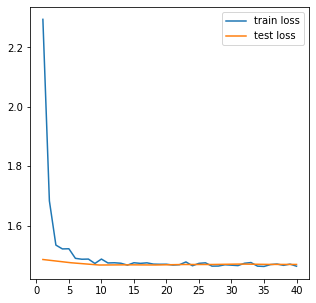

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.plot(np.linspace(1,len(tr_loss_array),len(tr_loss_array)),
         tr_loss_array, label='train loss')
plt.plot(np.linspace(1,len(tr_loss_array),len(te_loss_array)),
         te_loss_array, label='test loss')
plt.legend()
plt.show()

In [9]:
correct = 0
total = 0

with torch.no_grad():
  for image, label in test_loader:
    x = image.to(device)
    y_ = label.to(device)

    output = model(x)
    _,output_index = torch.max(output,1)

    total += label.size(0)
    correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(correct/total))  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of Test Data: 0.9944912195205688
